In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
import kinetic_errors
import importlib
importlib.reload(kinetic_errors)
from kinetic_errors import kinetic_model_errors
import random
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error


In [54]:
adsorption_data = pd.read_excel("Data/adsorption.xlsx")
adsorption_data

,Adsorbent type,m (g),H (cm),Q (ml/min),C0 (mg/L),tb (min),te (min),qtotal(mg),qe(mg/g),mtotal (mg),%R (mass%)
0,C-NFC,4,4,8,100,40,200,0.5668,0.1416,1.5220,36.52
1,C-NFC,8,8,8,100,115,300,1.2480,0.1560,2.3280,53.61
2,C-NFC,12,12,8,100,220,380,2.0712,0.2589,2.9490,70.23
3,C-NFC,4,4,4,100,135,340,0.7635,0.1909,1.3192,58.00
4,C-NFC,4,4,12,100,15,120,0.3467,0.0872,1.3970,28.84
5,C-NFC,4,4,8,150,15,95,0.1714,0.0426,0.9880,17.34
6,C-NFC,4,4,8,50,80,370,1.2758,0.3190,2.2790,56.00
7,MF-NFC,4,4,12,100,20,130,0.4764,0.1191,1.5288,31.16
8,CMNFC,4,4,12,100,50,150,0.7100,0.1775,1.7460,41.00
9,MF-MNFC,4,4,12,100,80,185,1.4300,0.3573,2.1534,66.41


Limited number of data available

In [55]:
## Clean names

col_names = adsorption_data.columns
col_names = [names.lower() for names in col_names]
adsorption_data.columns = col_names
adsorption_data.describe()

,m (g),h (cm),q (ml/min),c0 (mg/l),tb (min),te (min),qtotal(mg),qe(mg/g),mtotal (mg),%r (mass%)
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000
mean,5.200000,5.200000,9.200000,100.000000,77.000000,227.000000,0.905980,0.185010,1.82104,45.911000
std,2.699794,2.699794,2.699794,23.570226,65.243135,109.878721,0.586588,0.100059,0.59213,17.500638
min,4.000000,4.000000,4.000000,50.000000,15.000000,95.000000,0.171400,0.042600,0.98800,17.340000
25%,4.000000,4.000000,8.000000,100.000000,25.000000,135.000000,0.499000,0.124725,1.42825,32.500000
50%,4.000000,4.000000,8.000000,100.000000,65.000000,192.500000,0.736750,0.166750,1.63740,47.305000
75%,4.000000,4.000000,12.000000,100.000000,106.250000,330.000000,1.268850,0.241900,2.24760,57.500000
max,12.000000,12.000000,12.000000,150.000000,220.000000,380.000000,2.071200,0.357300,2.94900,70.230000


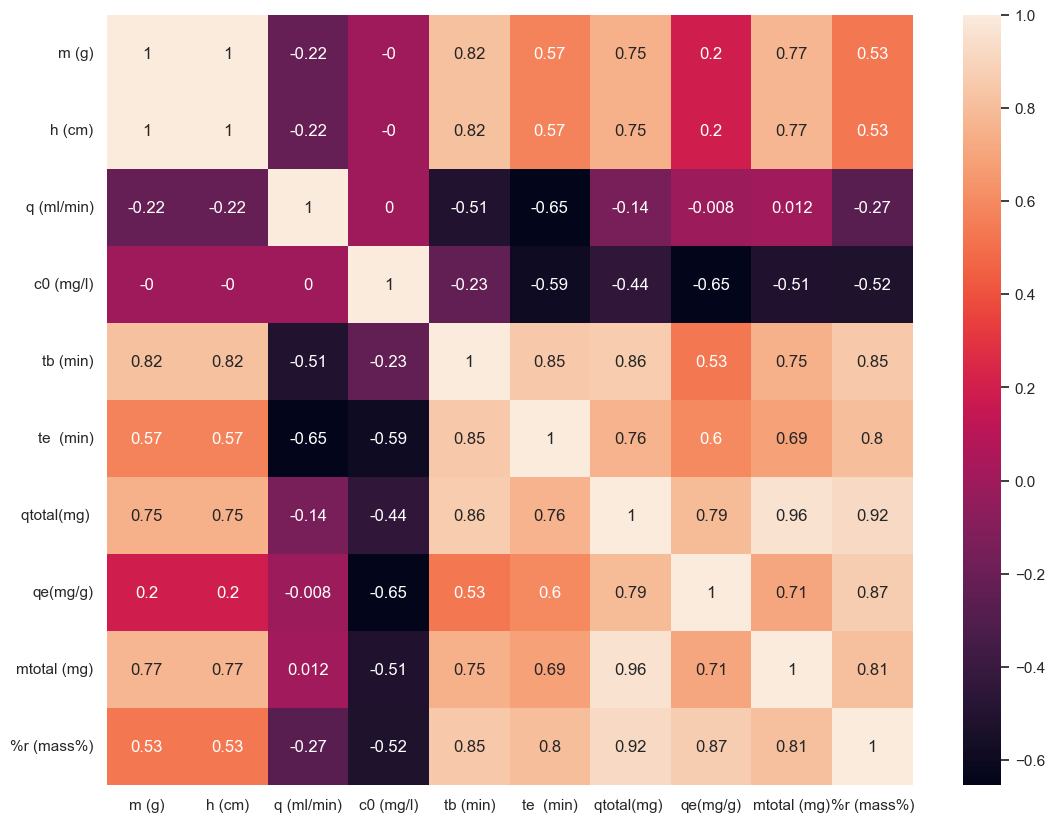

In [56]:
x = adsorption_data._get_numeric_data()
adsorption_corr = round(x.corr(), 3)
plt.figure(figsize=(13,10))
ax = sns.heatmap(adsorption_corr, annot=True)
plt.show(ax)

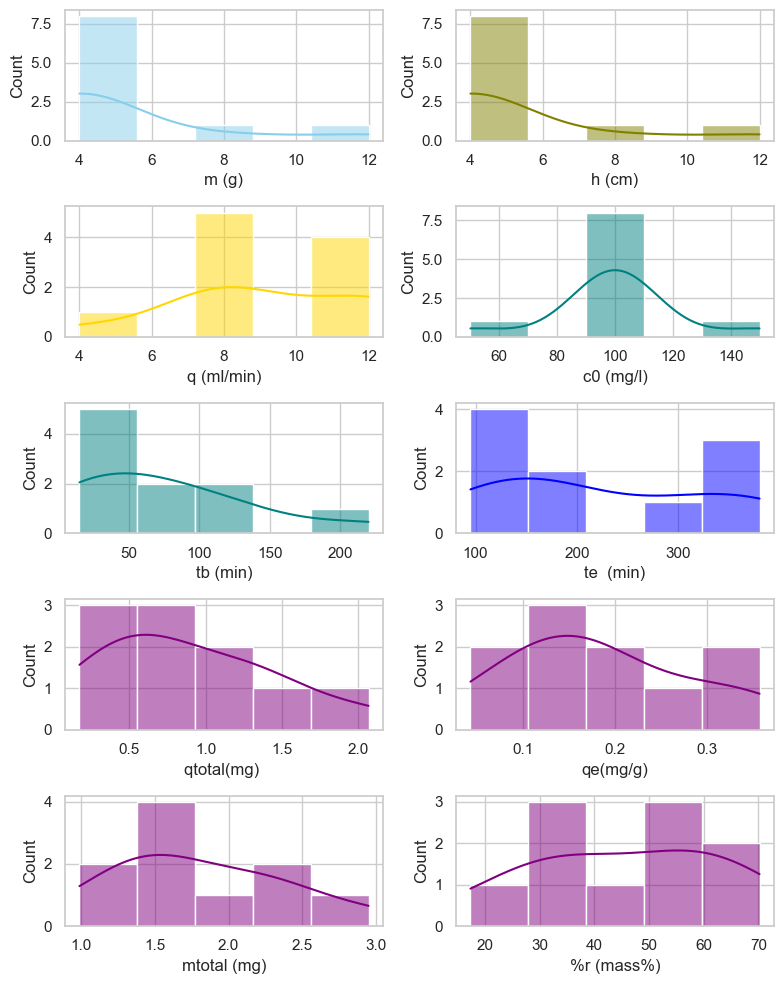

In [57]:
## Checking for outliers using histograms

sns.set(style="whitegrid")  
fig,axs = plt.subplots(5,2, figsize = (8,10))
sns.histplot(data=adsorption_data, x=x.columns[0], kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=adsorption_data, x=x.columns[1], kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=adsorption_data, x=x.columns[2], kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=adsorption_data, x=x.columns[3], kde=True, color="teal", ax=axs[1, 1])
sns.histplot(data=adsorption_data, x=x.columns[4], kde=True, color="teal", ax=axs[2, 0])
sns.histplot(data=adsorption_data, x=x.columns[5], kde=True, color="blue", ax=axs[2, 1])
sns.histplot(data=adsorption_data, x=x.columns[6], kde=True, color="purple", ax=axs[3,0])
sns.histplot(data=adsorption_data, x=x.columns[7], kde=True, color="purple", ax=axs[3,1])
sns.histplot(data=adsorption_data, x=x.columns[8], kde=True, color="purple", ax=axs[4,0])
sns.histplot(data=adsorption_data, x=x.columns[9], kde=True, color="purple", ax=axs[4,1])
fig.tight_layout()

In [58]:
## Split Data into test and train
## Limited number of dataset
## There is a total of 12 entries
from sklearn.preprocessing import StandardScaler

adsorption_num = adsorption_data._get_numeric_data()
features = adsorption_num.iloc[:,:-1]
target = adsorption_num.iloc[:,-1]

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(features)
y = sc_y.fit_transform(np.reshape(target, [-1, 1]))
features_train, features_test, target_train, target_test = train_test_split(X, y, test_size = .3, random_state=45)

print(features_train)
print(target_train)

[[-0.46852129 -0.46852129  1.09321633  0.         -0.43622212 -0.73867921
  -0.35217389 -0.07911598 -0.13358401]
 [-0.46852129 -0.46852129  1.09321633  0.          0.04846912 -0.40291593
   0.94165814  1.81503227  0.59165754]
 [-0.46852129 -0.46852129 -0.46852129 -2.23606798  0.04846912  1.37183281
   0.66456244  1.4115513   0.81524698]
 [-0.46852129 -0.46852129 -0.46852129  2.23606798 -1.00169525 -1.26630721
  -1.32003212 -1.50025391 -1.48295342]
 [-0.46852129 -0.46852129  1.09321633  0.         -0.92091337 -0.93054394
  -0.7719505  -0.69434545 -0.52023709]
 [-0.46852129 -0.46852129 -0.46852129  0.         -0.59778587 -0.25901738
  -0.6095027  -0.45731355 -0.53234225]
 [-0.46852129 -0.46852129 -2.0302589   0.          0.93706975  1.08403572
  -0.25603498  0.06204968 -0.89336087]]
[[-0.2957977 ]
 [ 1.23468886]
 [ 0.60767725]
 [-1.72087884]
 [-0.88847726]
 [-0.56563555]
 [ 0.72814057]]


Implementing Lasso Regression and GridSearchCV with Cross validation using repeatedKFolds to find the optimal alpha parameters.

In [59]:
## Implementing multiple Machine Learning models.
## LASSO REGRESSION

model = Lasso(random_state=10)
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=10)
lasso_results = model.fit(features_train, target_train)

lasso_pred = lasso_results.predict(features_test)
lasso_mse = mean_squared_error(y_pred=lasso_pred, y_true=target_test)
lasso_r2 = r2_score(y_pred=lasso_pred, y_true=target_test)
lasso_mae = mean_absolute_error(y_pred=lasso_pred, y_true=target_test)
lasso_rmse = np.sqrt(lasso_mse)

# print(f'Params: {lasso_results.best_params_}')

print(lasso_mse)
print(lasso_r2)
print(lasso_mae)
print(lasso_rmse)



1.2330081157456165
-0.1751672602063159
1.0284413056766752
1.1104089858001045


0.1641499533269218
0.8436
0.276
0.4052


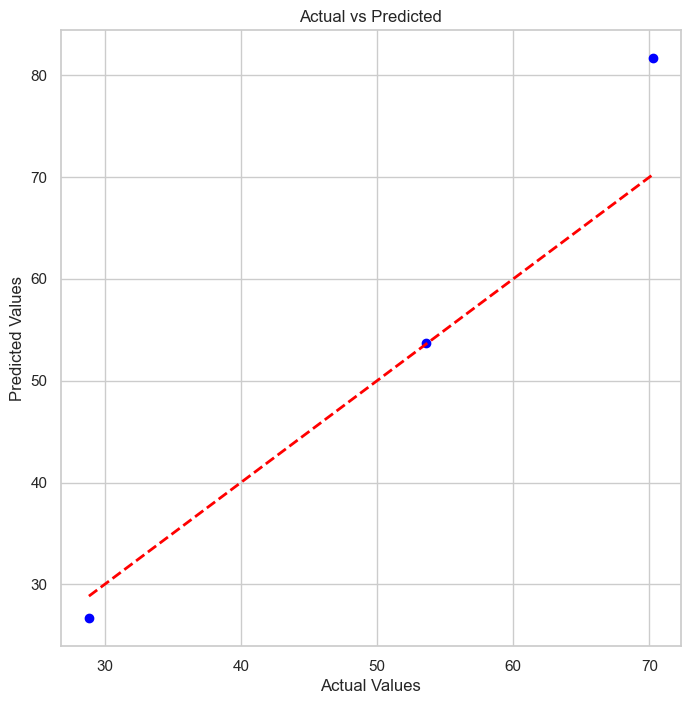

In [60]:
## RIDGE REGRESSION
ridge_model = Ridge(random_state=123)
# cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

ridge_results = ridge_model.fit(features_train, target_train)

ridge_pred = ridge_results.predict(features_test)

ridge_mse = mean_squared_error(y_pred=ridge_pred, y_true=target_test)
ridge_r2 = r2_score(y_pred=ridge_pred, y_true=target_test)
ridge_mae = mean_absolute_error(y_pred=ridge_pred, y_true=target_test)
ridge_rmse = np.sqrt(ridge_mse)

print(ridge_mse)
print(round(ridge_r2, 4))
print(round(ridge_mae, 4))
print(round(ridge_rmse, 4))

y_pred = sc_y.inverse_transform(np.reshape(ridge_pred, [-1,1]))
y_true = sc_y.inverse_transform(np.reshape(target_test, [-1,1]))

plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, color='blue', marker='o')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

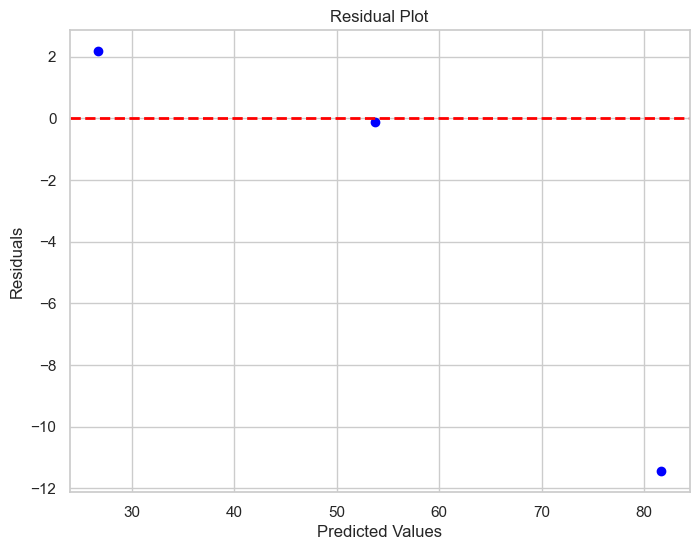

In [61]:
residuals = np.array(y_true) - np.array(y_pred)

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue', marker='o')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

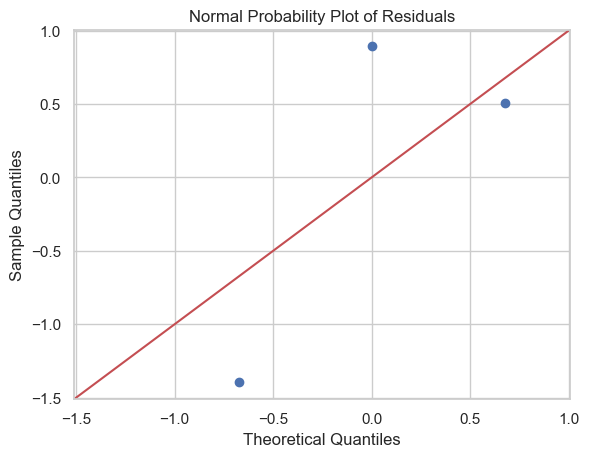

In [62]:
import statsmodels.api as sm
sm.qqplot(np.array(residuals), line='45', fit=True)
plt.title('Normal Probability Plot of Residuals')
plt.show()

In [63]:


forest_model = RandomForestRegressor(random_state=10)
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

random.seed(12)
forest_results = forest_model.fit(features_train, target_train)

forest_pred = forest_results.predict(features_test)
forest_mse = mean_squared_error(y_pred=forest_pred, y_true=target_test)
forest_r2 = r2_score(y_pred=forest_pred, y_true=target_test)
forest_mae = mean_absolute_error(y_pred=forest_pred, y_true= target_test)
forest_rmse = np.sqrt(forest_mse)


print(round(forest_mse, 4))
print(round(forest_r2, 4))
print(round(forest_mae, 4))
print(round(forest_rmse, 4))

y_pred = sc_y.inverse_transform(np.reshape(forest_pred, [-1,1]))
y_true = sc_y.inverse_transform(np.reshape(target_test, [-1,1]))



c:\Users\ZBOOK\AppData\Local\R-MINI~1\envs\adsorption_rate\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.1998
0.8096
0.2706
0.447


In [64]:
## For this analysis, Random Forest regression will be used, It fits our model very well, with 
## low r-squared value, and minimum mean squared error.

In [65]:
regressor = SVR(kernel = 'rbf')
regressor.fit(features_train, target_train)
svc_pred = regressor.predict(features_test)
# svc_pred = sc_y.inverse_transform(np.reshape(svc_pred, [-1,1]))
# target_test = sc_y.inverse_transform(np.reshape(target_test, [-1,1]))

svc_mse = mean_squared_error(y_pred=svc_pred, y_true=target_test)
svc_r2 = r2_score(y_pred=svc_pred, y_true=target_test)
svc_mae = mean_absolute_error(y_pred=svc_pred, y_true=target_test)
svc_rmse = np.sqrt(svc_mse)

print(round(svc_mse, 4))
print(round(svc_r2, 4))
print(round(svc_mae, 4))
print(round(svc_rmse, 4))



0.6945
0.3381
0.6107
0.8334


c:\Users\ZBOOK\AppData\Local\R-MINI~1\envs\adsorption_rate\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [66]:
## Implementing Kinetic models

## Using etuks original dataset on the effect of different parameters on Co(II) ions adsorption

bed_heights = pd.read_excel("Data/etuk's data.xlsx", sheet_name="BedHeights")
flow_rates = pd.read_excel("Data/etuk's data.xlsx", sheet_name="FlowRates")
concentration = pd.read_excel("Data/etuk's data.xlsx", sheet_name="Concentration")
absorbents = pd.read_excel("Data/etuk's data.xlsx", sheet_name="Absorbent")
print(bed_heights.head(3))
print(flow_rates.head(3))
print(concentration.head(3))
print(absorbents.head(3))


   bh  t (min)  qexp
0  12        0   0.0
1  12       20   0.0
2  12       30   0.0
   fr  t (min)  qexp
0   4        0   0.0
1   4       20   0.0
2   4       30   0.0
   bh  co  t (min)  qexp
0   4  50        0   0.0
1   4  50       10   0.0
2   4  50       22   0.0
  absorbent  t (min)  qexp
0   MF-MNFC        0   0.0
1   MF-MNFC       20   0.0
2   MF-MNFC       40   0.0


In [67]:
def calculate_AUC(DATASET, FILTER, FILTER_VALUE):
    auc_arr = []
    bed_heights_val = DATASET[DATASET[FILTER] == FILTER_VALUE]
    bed_heights_val = bed_heights_val.reset_index().drop(columns='index')
    qexp = bed_heights_val['qexp']
    time = bed_heights_val['t (min)']
    for i in range(len(qexp) - 1):
        auc = (qexp[i] + qexp[i+1]) / 2 * (time[i+1] - time[i])
        auc_arr.append(auc)

    if len(qexp) > 1:
        auc_last = (time[len(qexp) - 2] + time[len(qexp) - 1]) / 2 * (qexp[len(qexp) - 1] - qexp[len(qexp) - 2])
        auc_arr.append(auc_last)

    bed_heights_val['AUC'] = auc_arr
    return bed_heights_val

In [68]:
bed_12 = calculate_AUC(DATASET=bed_heights, FILTER='bh', FILTER_VALUE=12)
bed_8 = calculate_AUC(DATASET=bed_heights, FILTER='bh', FILTER_VALUE=8)
bed_4 = calculate_AUC(DATASET=bed_heights, FILTER='bh', FILTER_VALUE=4)
flow_4 = calculate_AUC(DATASET=flow_rates, FILTER='fr', FILTER_VALUE=4)
flow_8 = calculate_AUC(DATASET=flow_rates, FILTER='fr', FILTER_VALUE=8)
flow_12 = calculate_AUC(DATASET=flow_rates, FILTER='fr', FILTER_VALUE=12)
conc_50 = calculate_AUC(DATASET=concentration, FILTER='co', FILTER_VALUE=50)
conc_100 = calculate_AUC(DATASET=concentration, FILTER='co', FILTER_VALUE=100)
conc_150 = calculate_AUC(DATASET=concentration, FILTER='co', FILTER_VALUE=150)
absorbs_MF_MNFC = calculate_AUC(DATASET=absorbents, FILTER='absorbent', FILTER_VALUE="MF-MNFC")
absorbs_C_MNFC = calculate_AUC(DATASET=absorbents, FILTER='absorbent', FILTER_VALUE="C-MNFC")
absorbs_C_NFC = calculate_AUC(DATASET=absorbents, FILTER='absorbent', FILTER_VALUE="C-NFC")
absorbs_MF_NFC = calculate_AUC(DATASET=absorbents, FILTER='absorbent', FILTER_VALUE="MF-NFC")

In [69]:
## Plot against time for all instances

bed_heights_AUC = pd.concat([bed_4, bed_8, bed_12], ignore_index=True)
flow_rates_AUC = pd.concat([flow_4, flow_8, flow_12], ignore_index=True)
conc_AUC = pd.concat([conc_100, conc_150, conc_50], ignore_index=True)
absorbents_AUC = pd.concat([absorbs_MF_MNFC, absorbs_C_MNFC, absorbs_C_NFC, absorbs_MF_NFC], ignore_index=True)

bed_heights_AUC['bh'] = bed_heights_AUC['bh'].astype('category')
flow_rates_AUC['fr'] = flow_rates_AUC['fr'].astype('category')
conc_AUC['co'] = conc_AUC['co'].astype('category')
absorbents_AUC['absorbent'] = absorbents_AUC['absorbent'].astype("category")

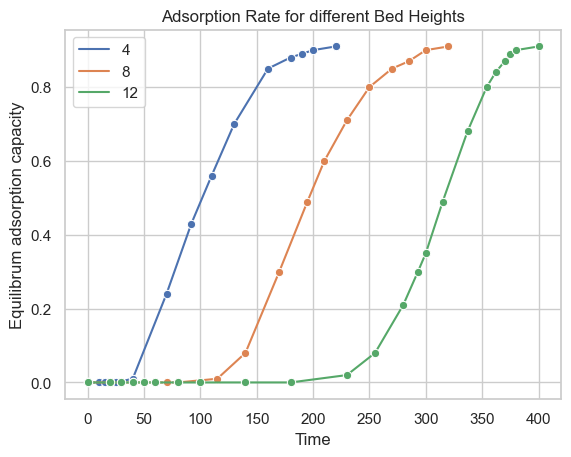

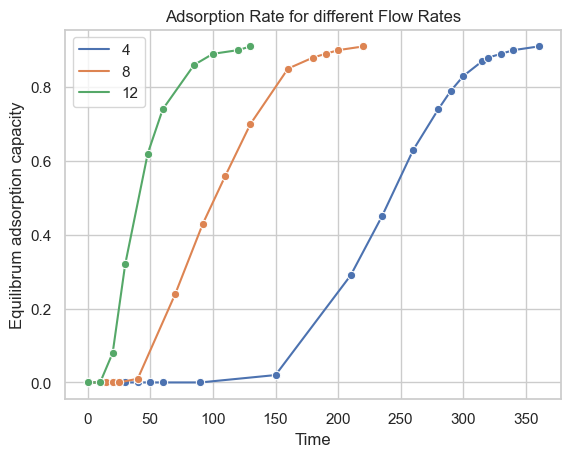

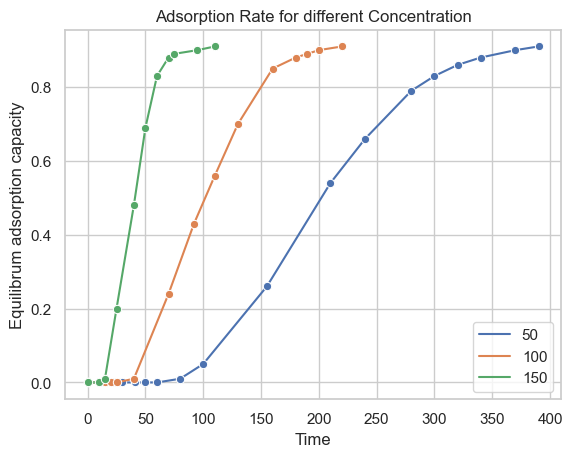

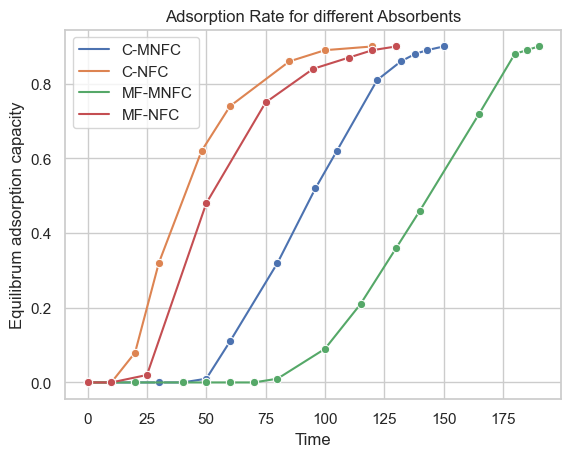

In [70]:
def plot_PARAMS(DATA, title = "", hue=""):
    sns.lineplot(data=DATA, x='t (min)', y = 'qexp', hue= hue, marker='o')
    plt.ylabel('Equilibrum adsorption capacity')
    plt.xlabel('Time')
    plt.title(title)
    plt.legend()
    plt.show()

plot_PARAMS(DATA=bed_heights_AUC, title="Adsorption Rate for different Bed Heights", hue='bh')
plot_PARAMS(DATA=flow_rates_AUC, title="Adsorption Rate for different Flow Rates", hue='fr')
plot_PARAMS(DATA=conc_AUC, title="Adsorption Rate for different Concentration", hue='co')
plot_PARAMS(DATA=absorbents_AUC, title="Adsorption Rate for different Absorbents", hue='absorbent')

rsquared: 0.98497 Y = 1 / 1 + e^(-0.00035 * 21342.07 * 4/8) + 0.00034642101926132156 * 100 * X
rsquared: 0.99185 Y = 1 / 1 + e^(-0.00029 * 20161.6 * 8/8) + 0.0002939950384686376 * 100 * X
rsquared: 0.9991 Y = 1 / 1 + e^(-0.00036 * 21125.99 * 12/8) + 0.0003622699415871324 * 100 * X


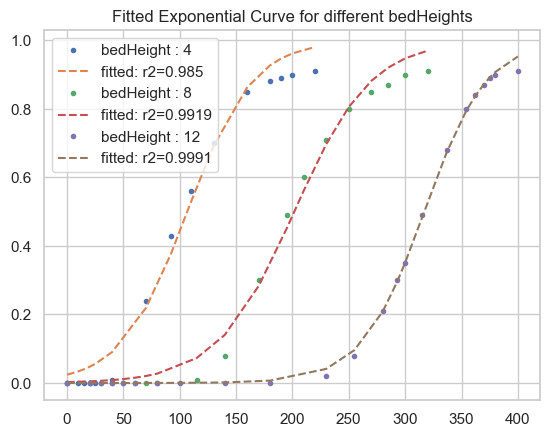

In [71]:
import thomas_kinetic_model
importlib.reload(thomas_kinetic_model)
from thomas_kinetic_model import fit_thomas_kinetic_model

bed_4_model_params = fit_thomas_kinetic_model(bed_4, m=4, Co= 100, Q=8, name="bedHeight", value=4)
bed_8_model_params = fit_thomas_kinetic_model(bed_8, m=8, Co=100, Q=8, name="bedHeight", value=8)
bed_12_model_params = fit_thomas_kinetic_model(bed_12, m=12, Co=100, Q=8, name="bedHeight", value=12)

In [72]:


def ret(var):
    name = [ (k,v) for k,v in globals().items() if v is var][0][0]
    return name
ret(bed_12)


'bed_12'

rsquared: 0.99731 Y = 1 / 1 + e^(-0.00027 * 24331.21 * 4/4) + 0.000270666601587423 * 100 * X
rsquared: 0.98497 Y = 1 / 1 + e^(-0.00035 * 21342.07 * 4/8) + 0.00034642101926132156 * 100 * X
rsquared: 0.96231 Y = 1 / 1 + e^(-0.00072 * 13316.55 * 4/12) + 0.000718907186039845 * 100 * X


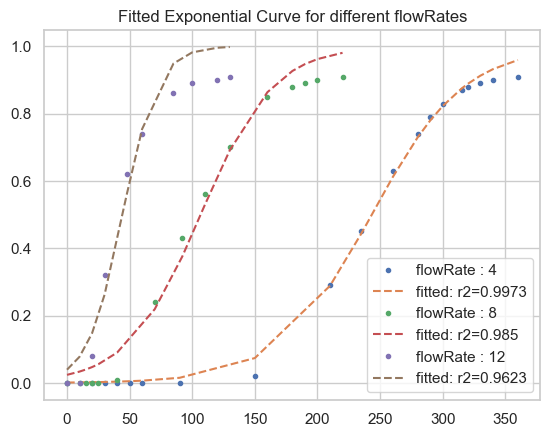

In [73]:
flow_4_model_params = fit_thomas_kinetic_model(flow_4, m=4, Co= 100, Q=4, name="flowRate", value=4)
flow_8_model_params = fit_thomas_kinetic_model(flow_8, m=4, Co=100, Q=8, name="flowRate", value=8)
flow_12_model_params = fit_thomas_kinetic_model(flow_12, m=4, Co=100, Q=12, name="flowRate", value=12)

rsquared: 0.99053 Y = 1 / 1 + e^(-0.0004 * 21348.74 * 4/8) + 0.00040154148246879234 * 50 * X
rsquared: 0.98497 Y = 1 / 1 + e^(-0.00035 * 21342.07 * 4/8) + 0.00034642101926132156 * 100 * X
rsquared: 0.98016 Y = 1 / 1 + e^(-0.00059 * 12661.38 * 4/8) + 0.0005910186750216731 * 150 * X


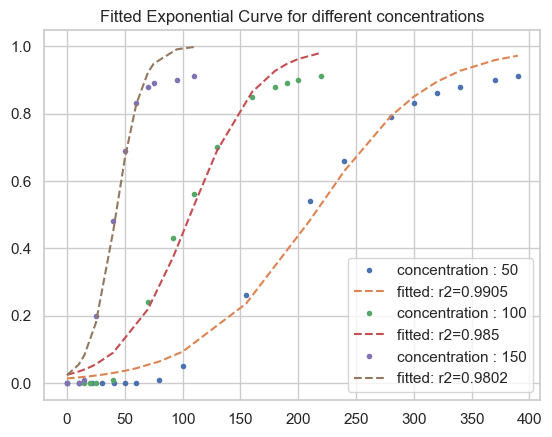

In [74]:
conc_50_model_params = fit_thomas_kinetic_model(data=conc_50, m=4, Co=50, Q=8, name="concentration", value=50)
conc_100_model_params = fit_thomas_kinetic_model(data=conc_100, m=4, Co=100, Q=8, name="concentration", value=100)
conc_150_model_params = fit_thomas_kinetic_model(data=conc_150, m=4, Co=150, Q=8, name="concentration", value=150)

rsquared: 0.96342 Y = 1 / 1 + e^(-0.00056 * 17572.5 * 4/12) + 0.0005576796986316646 * 100 * X
rsquared: 0.96374 Y = 1 / 1 + e^(-0.00072 * 13299.4 * 4/12) + 0.0007242384401391434 * 100 * X
rsquared: 0.99797 Y = 1 / 1 + e^(-0.0005 * 42994.87 * 4/12) + 0.0004998825554739557 * 100 * X
rsquared: 0.99346 Y = 1 / 1 + e^(-0.00054 * 28966.9 * 4/12) + 0.0005420335313316439 * 100 * X


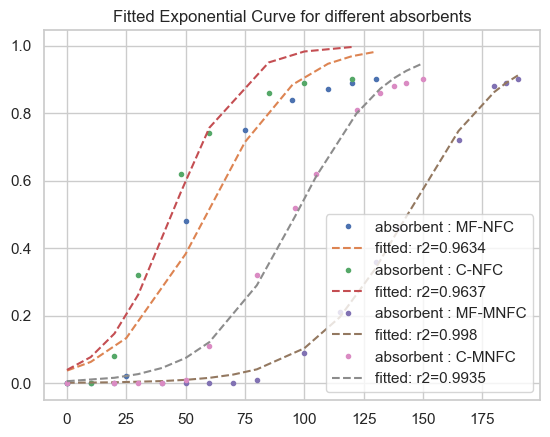

In [75]:
mf_nfc_model_params = fit_thomas_kinetic_model(absorbs_MF_NFC, Co=100, m=4, Q=12,name="absorbent", value="MF-NFC")
c_nfc_model_params = fit_thomas_kinetic_model(absorbs_C_NFC, Co=100, m=4, Q=12,name="absorbent", value="C-NFC")
mf_mnfc_model_params = fit_thomas_kinetic_model(absorbs_MF_MNFC, Co=100, m=4, Q=12,name="absorbent", value="MF-MNFC")
c_mnfc_model_params = fit_thomas_kinetic_model(absorbs_C_MNFC, Co=100, m=4, Q=12,name="absorbent", value="C-MNFC")

In [76]:
bed_4_errors = kinetic_model_errors(bed_4_model_params[1])
bed_8_errors = kinetic_model_errors(bed_8_model_params[1])
bed_12_errors = kinetic_model_errors(bed_12_model_params[1])
flow_4_errors = kinetic_model_errors(flow_4_model_params[1])
flow_8_errors = kinetic_model_errors(flow_8_model_params[1])
flow_12_errors = kinetic_model_errors(flow_12_model_params[1])
conc_50_errors = kinetic_model_errors(conc_50_model_params[1])
conc_100_errors = kinetic_model_errors(conc_100_model_params[1])
conc_150_errors = kinetic_model_errors(conc_150_model_params[1])
mf_mnfc_errors = kinetic_model_errors(mf_mnfc_model_params[1])
c_mnfc_errors = kinetic_model_errors(c_mnfc_model_params[1])
mf_nfc_errors = kinetic_model_errors(mf_nfc_model_params[1])
c_nfc_errors = kinetic_model_errors(c_nfc_model_params[1])

c:\Users\ZBOOK\AppData\Local\R-MINI~1\envs\adsorption_rate\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


rsquared: 0.985 Y = e^((0.035 * t)-(0.035 * 106.71)) / 1 + e^((0.03464186890244401 * t - (0.03464186890244401 * 106.71046882246937)
rsquared: 0.9919 Y = e^((0.029 * t)-(0.029 * 201.616)) / 1 + e^((0.02939959210692213 * t - (0.02939959210692213 * 201.61618012997093)
rsquared: 0.9991 Y = e^((0.036 * t)-(0.036 * 316.89)) / 1 + e^((0.03622699794883953 * t - (0.03622699794883953 * 316.88980507814705)


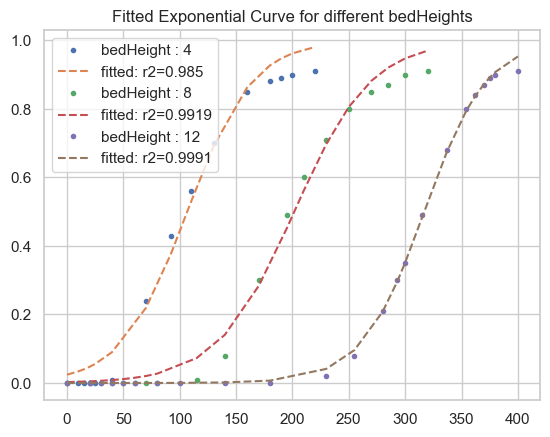

In [77]:
## YOON NELSON 
import yoon_nelson_kinetic_models
importlib.reload(yoon_nelson_kinetic_models)
from yoon_nelson_kinetic_models import fit_yoon_nelson_kinetic_model

yoon_bed_4_model_params = fit_yoon_nelson_kinetic_model(bed_4, m=4, Co= 100, Q=8, name="bedHeight", value=4)
yoon_bed_8_model_params = fit_yoon_nelson_kinetic_model(bed_8, m=8, Co=100, Q=8, name="bedHeight", value=8)
yoon_bed_12_model_params = fit_yoon_nelson_kinetic_model(bed_12, m=12, Co=100, Q=8, name="bedHeight", value=12)


rsquared: 0.9973 Y = e^((0.027 * t)-(0.027 * 243.312)) / 1 + e^((0.027066655143458008 * t - (0.027066655143458008 * 243.31214462310808)
rsquared: 0.985 Y = e^((0.035 * t)-(0.035 * 106.71)) / 1 + e^((0.03464186890244401 * t - (0.03464186890244401 * 106.71046882246937)
rsquared: 0.9623 Y = e^((0.072 * t)-(0.072 * 44.388)) / 1 + e^((0.07189123956149689 * t - (0.07189123956149689 * 44.388392297628535)


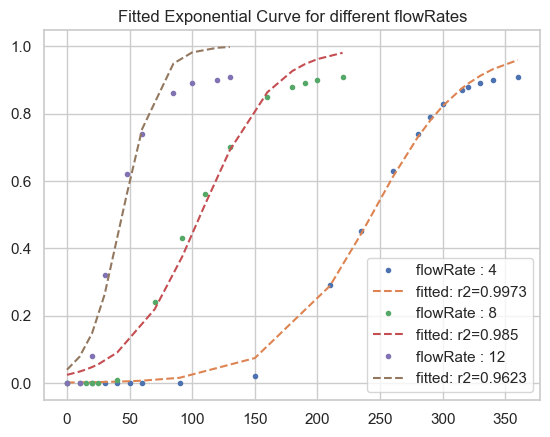

In [78]:
yoon_flow_4_model_params = fit_yoon_nelson_kinetic_model(flow_4, m=4, Co= 100, Q=4, name="flowRate", value=4)
yoon_flow_8_model_params = fit_yoon_nelson_kinetic_model(flow_8, m=4, Co=100, Q=8, name="flowRate", value=8)
yoon_flow_12_model_params = fit_yoon_nelson_kinetic_model(flow_12, m=4, Co=100, Q=12, name="flowRate", value=12)

rsquared: 0.9905 Y = e^((0.02 * t)-(0.02 * 213.487)) / 1 + e^((0.020076976569272407 * t - (0.020076976569272407 * 213.48747925839177)
rsquared: 0.985 Y = e^((0.035 * t)-(0.035 * 106.71)) / 1 + e^((0.03464186890244401 * t - (0.03464186890244401 * 106.71046882246937)
rsquared: 0.9802 Y = e^((0.089 * t)-(0.089 * 42.205)) / 1 + e^((0.08865275861829412 * t - (0.08865275861829412 * 42.20461534979938)


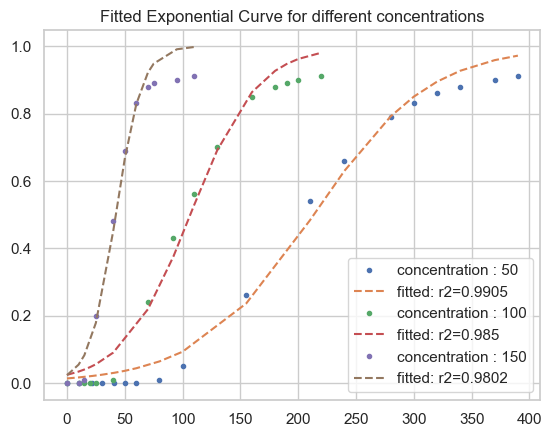

In [79]:
yoon_conc_50_model_params = fit_yoon_nelson_kinetic_model(data=conc_50, m=4, Co=50, Q=8, name="concentration", value=50)
yoon_conc_100_model_params = fit_yoon_nelson_kinetic_model(data=conc_100, m=4, Co=100, Q=8, name="concentration", value=100)
yoon_conc_150_model_params = fit_yoon_nelson_kinetic_model(data=conc_150, m=4, Co=150, Q=8, name="concentration", value=150)

rsquared: 0.9634 Y = e^((0.056 * t)-(0.056 * 58.575)) / 1 + e^((0.055766365771363645 * t - (0.055766365771363645 * 58.57542728649009)
rsquared: 0.9637 Y = e^((0.072 * t)-(0.072 * 44.331)) / 1 + e^((0.07242326057385681 * t - (0.07242326057385681 * 44.331444805948955)
rsquared: 0.998 Y = e^((0.05 * t)-(0.05 * 143.316)) / 1 + e^((0.049988230850793285 * t - (0.049988230850793285 * 143.3162444492374)
rsquared: 0.9935 Y = e^((0.054 * t)-(0.054 * 96.556)) / 1 + e^((0.05420336787122591 * t - (0.05420336787122591 * 96.55635142588336)


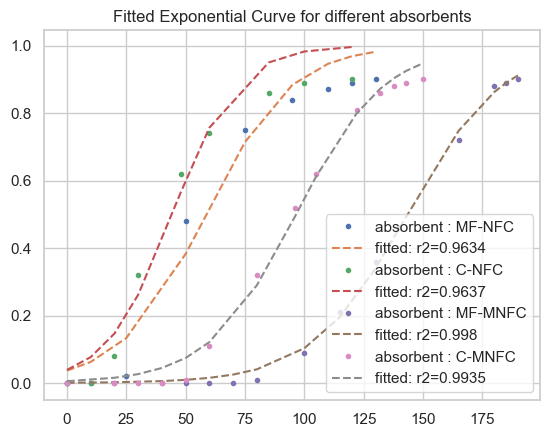

In [80]:
yoon_mf_nfc_model_params = fit_yoon_nelson_kinetic_model(absorbs_MF_NFC, Co=100, m=4, Q=12,name="absorbent", value="MF-NFC")
yoon_c_nfc_model_params = fit_yoon_nelson_kinetic_model(absorbs_C_NFC, Co=100, m=4, Q=12,name="absorbent", value="C-NFC")
yoon_mf_mnfc_model_params = fit_yoon_nelson_kinetic_model(absorbs_MF_MNFC, Co=100, m=4, Q=12,name="absorbent", value="MF-MNFC")
yoon_c_mnfc_model_params = fit_yoon_nelson_kinetic_model(absorbs_C_MNFC, Co=100, m=4, Q=12,name="absorbent", value="C-MNFC")

In [81]:
yoon_bed_4_errors = kinetic_model_errors(bed_4_model_params[1])
yoon_bed_8_errors = kinetic_model_errors(bed_8_model_params[1])
yoon_bed_12_errors = kinetic_model_errors(bed_12_model_params[1])
yoon_flow_4_errors = kinetic_model_errors(flow_4_model_params[1])
yoon_flow_8_errors = kinetic_model_errors(flow_8_model_params[1])
yoon_flow_12_errors = kinetic_model_errors(flow_12_model_params[1])
yoon_conc_50_errors = kinetic_model_errors(conc_50_model_params[1])
yoon_conc_100_errors = kinetic_model_errors(conc_100_model_params[1])
yoon_conc_150_errors = kinetic_model_errors(conc_150_model_params[1])
yoon_mf_mnfc_errors = kinetic_model_errors(mf_mnfc_model_params[1])
yoon_c_mnfc_errors = kinetic_model_errors(c_mnfc_model_params[1])
yoon_mf_nfc_errors = kinetic_model_errors(mf_nfc_model_params[1])
yoon_c_nfc_errors = kinetic_model_errors(c_nfc_model_params[1])

rsquared: 0.9932 Y = 1 - e^(-(t/123.844)^2.156)
rsquared: 0.9898 Y = 1 - e^(-(t/222.879)^3.774)
rsquared: 0.9966 Y = 1 - e^(-(t/334.973)^7.645)


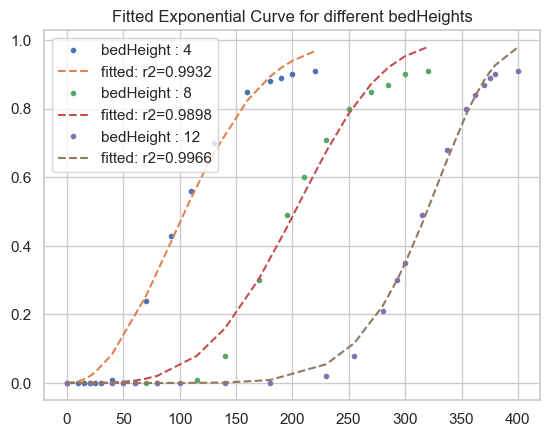

In [82]:
import weibull_kinetic_model
importlib.reload(weibull_kinetic_model)
from weibull_kinetic_model import fit_weibull_kinetic_model


wei_bed_4_model_params = fit_weibull_kinetic_model(bed_4, m=4, Co= 100, Q=8, name="bedHeight", value=4)
wei_bed_8_model_params = fit_weibull_kinetic_model(bed_8, m=8, Co=100, Q=8, name="bedHeight", value=8)
wei_bed_12_model_params = fit_weibull_kinetic_model(bed_12, m=12, Co=100, Q=8, name="bedHeight", value=12)


rsquared: 0.9953 Y = 1 - e^(-(t/265.428)^4.261)
rsquared: 0.9932 Y = 1 - e^(-(t/123.844)^2.156)
rsquared: 0.9765 Y = 1 - e^(-(t/54.209)^1.681)


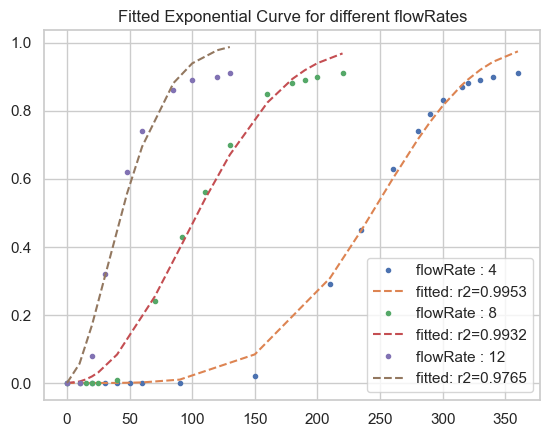

In [83]:
wei_flow_4_model_params = fit_weibull_kinetic_model(flow_4, m=4, Co= 100, Q=4, name="flowRate", value=4)
wei_flow_8_model_params = fit_weibull_kinetic_model(flow_8, m=4, Co=100, Q=8, name="flowRate", value=8)
wei_flow_12_model_params = fit_weibull_kinetic_model(flow_12, m=4, Co=100, Q=12, name="flowRate", value=12)

rsquared: 0.9943 Y = 1 - e^(-(t/241.665)^2.572)
rsquared: 0.9932 Y = 1 - e^(-(t/123.844)^2.156)
rsquared: 0.985 Y = 1 - e^(-(t/48.491)^2.241)


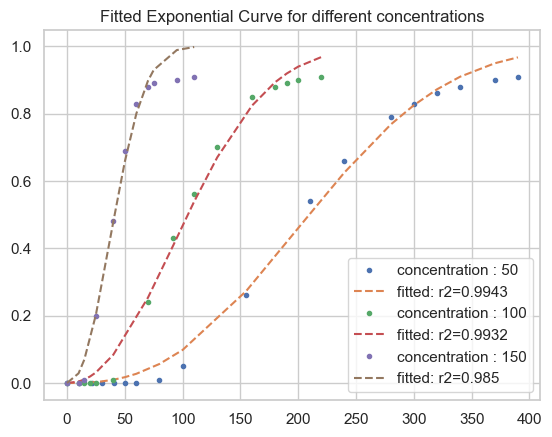

In [84]:
wei_conc_50_model_params = fit_weibull_kinetic_model(data=conc_50, m=4, Co=50, Q=8, name="concentration", value=50)
wei_conc_100_model_params = fit_weibull_kinetic_model(data=conc_100, m=4, Co=100, Q=8, name="concentration", value=100)
wei_conc_150_model_params = fit_weibull_kinetic_model(data=conc_150, m=4, Co=150, Q=8, name="concentration", value=150)

rsquared: 0.9779 Y = 1 - e^(-(t/68.946)^1.863)
rsquared: 0.9786 Y = 1 - e^(-(t/53.598)^1.743)
rsquared: 0.9982 Y = 1 - e^(-(t/155.958)^4.799)
rsquared: 0.994 Y = 1 - e^(-(t/107.652)^3.35)


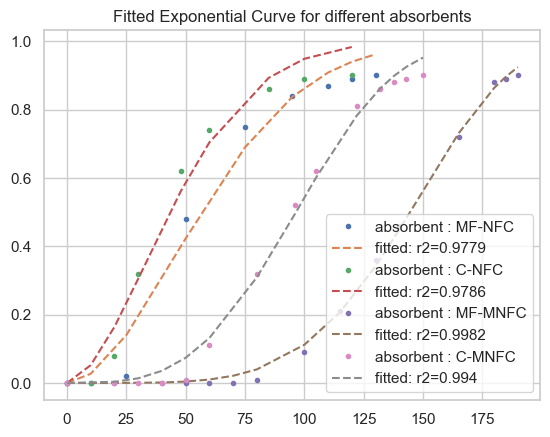

In [85]:
wei_mf_nfc_model_params = fit_weibull_kinetic_model(absorbs_MF_NFC, Co=100, m=4, Q=12,name="absorbent", value="MF-NFC")
wei_c_nfc_model_params = fit_weibull_kinetic_model(absorbs_C_NFC, Co=100, m=4, Q=12,name="absorbent", value="C-NFC")
wei_mf_mnfc_model_params = fit_weibull_kinetic_model(absorbs_MF_MNFC, Co=100, m=4, Q=12,name="absorbent", value="MF-MNFC")
wei_c_mnfc_model_params = fit_weibull_kinetic_model(absorbs_C_MNFC, Co=100, m=4, Q=12,name="absorbent", value="C-MNFC")

In [86]:
wei_bed_4_errors = kinetic_model_errors(wei_bed_4_model_params[1])
wei_bed_8_errors = kinetic_model_errors(wei_bed_8_model_params[1])
wei_bed_12_errors = kinetic_model_errors(wei_bed_12_model_params[1])
wei_flow_4_errors = kinetic_model_errors(wei_flow_4_model_params[1])
wei_flow_8_errors = kinetic_model_errors(wei_flow_8_model_params[1])
wei_flow_12_errors = kinetic_model_errors(wei_flow_12_model_params[1])
wei_conc_50_errors = kinetic_model_errors(wei_conc_50_model_params[1])
wei_conc_100_errors = kinetic_model_errors(wei_conc_100_model_params[1])
wei_conc_150_errors = kinetic_model_errors(wei_conc_150_model_params[1])
wei_mf_mnfc_errors = kinetic_model_errors(wei_mf_mnfc_model_params[1])
wei_c_mnfc_errors = kinetic_model_errors(wei_c_mnfc_model_params[1])
wei_mf_nfc_errors = kinetic_model_errors(wei_mf_nfc_model_params[1])
wei_c_nfc_errors = kinetic_model_errors(wei_c_nfc_model_params[1])

rsquared: 0.9988 Y = 1 - 1 / 1 + ((0.001 * 8 * 100/20.153 * 4) * t) ^ 3.366))
rsquared: 0.9982 Y = 1 - 1 / 1 + ((0.001 * 8 * 100/19.811 * 8) * t) ^ 5.795))
rsquared: 0.9996 Y = 1 - 1 / 1 + ((0.001 * 8 * 100/21.027 * 12) * t) ^ 11.628))


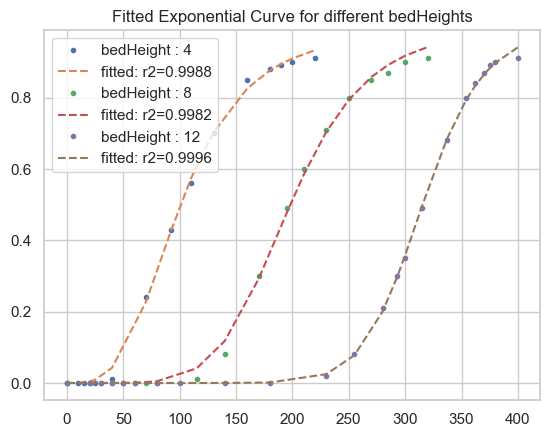

In [87]:
import yan_kinetic_model
importlib.reload(yan_kinetic_model)
from yan_kinetic_model import yan_kinetic_model


yan_bed_4_model_params = yan_kinetic_model(bed_4, m=4, Co= 100, Q=8, name="bedHeight", value=4)
yan_bed_8_model_params = yan_kinetic_model(bed_8, m=8, Co=100, Q=8, name="bedHeight", value=8)
yan_bed_12_model_params = yan_kinetic_model(bed_12, m=12, Co=100, Q=8, name="bedHeight", value=12)

rsquared: 0.9994 Y = 1 - 1 / 1 + ((0.001 * 4 * 100/24.063 * 4) * t) ^ 6.834))
rsquared: 0.9988 Y = 1 - 1 / 1 + ((0.001 * 8 * 100/20.153 * 4) * t) ^ 3.366))
rsquared: 0.9941 Y = 1 - 1 / 1 + ((0.001 * 12 * 100/12.411 * 4) * t) ^ 2.583))


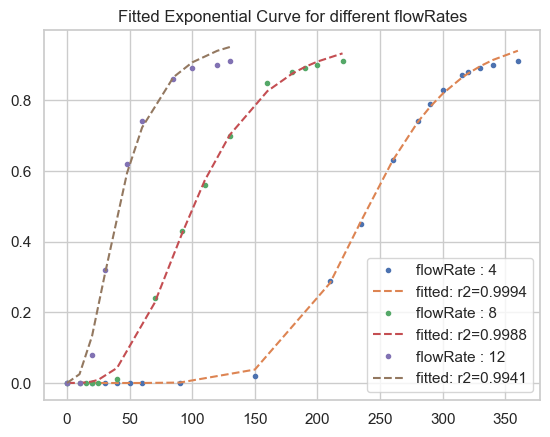

In [88]:
yan_flow_4_model_params = yan_kinetic_model(flow_4, m=4, Co= 100, Q=4, name="flowRate", value=4)
yan_flow_8_model_params = yan_kinetic_model(flow_8, m=4, Co=100, Q=8, name="flowRate", value=8)
yan_flow_12_model_params = yan_kinetic_model(flow_12, m=4, Co=100, Q=12, name="flowRate", value=12)

rsquared: 0.9996 Y = 1 - 1 / 1 + ((0.001 * 8 * 50/20.253 * 4) * t) ^ 3.928))
rsquared: 0.9988 Y = 1 - 1 / 1 + ((0.001 * 8 * 100/20.153 * 4) * t) ^ 3.366))
rsquared: 0.9945 Y = 1 - 1 / 1 + ((0.001 * 8 * 150/11.891 * 4) * t) ^ 3.262))


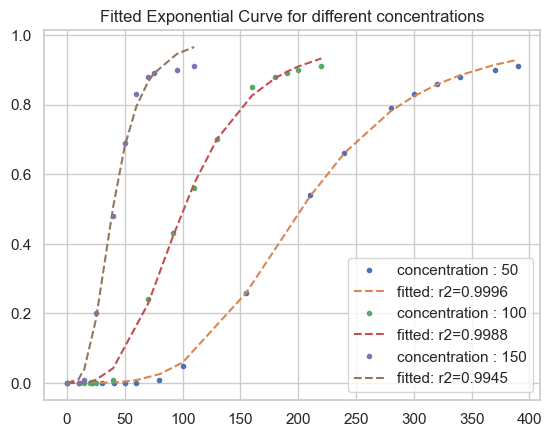

In [89]:
yan_conc_50_model_params = yan_kinetic_model(data=conc_50, m=4, Co=50, Q=8, name="concentration", value=50)
yan_conc_100_model_params = yan_kinetic_model(data=conc_100, m=4, Co=100, Q=8, name="concentration", value=100)
yan_conc_150_model_params = yan_kinetic_model(data=conc_150, m=4, Co=150, Q=8, name="concentration", value=150)

rsquared: 0.9931 Y = 1 - 1 / 1 + ((0.001 * 12 * 100/16.162 * 4) * t) ^ 2.986))
rsquared: 0.9948 Y = 1 - 1 / 1 + ((0.001 * 12 * 100/12.379 * 4) * t) ^ 2.644))
rsquared: 0.9981 Y = 1 - 1 / 1 + ((0.001 * 12 * 100/42.383 * 4) * t) ^ 7.109))
rsquared: 0.9987 Y = 1 - 1 / 1 + ((0.001 * 12 * 100/28.168 * 4) * t) ^ 5.077))


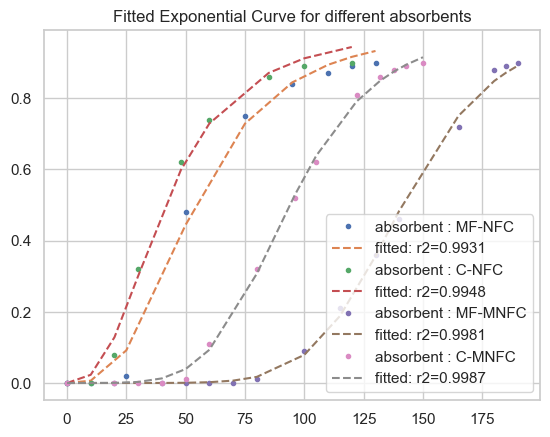

In [90]:
yan_mf_nfc_model_params = yan_kinetic_model(absorbs_MF_NFC, Co=100, m=4, Q=12,name="absorbent", value="MF-NFC")
yan_c_nfc_model_params = yan_kinetic_model(absorbs_C_NFC, Co=100, m=4, Q=12,name="absorbent", value="C-NFC")
yan_mf_mnfc_model_params = yan_kinetic_model(absorbs_MF_MNFC, Co=100, m=4, Q=12,name="absorbent", value="MF-MNFC")
yan_c_mnfc_model_params = yan_kinetic_model(absorbs_C_MNFC, Co=100, m=4, Q=12,name="absorbent", value="C-MNFC")

In [91]:
yan_bed_4_errors = kinetic_model_errors(yan_bed_4_model_params[1])
yan_bed_8_errors = kinetic_model_errors(yan_bed_8_model_params[1])
yan_bed_12_errors = kinetic_model_errors(yan_bed_12_model_params[1])
yan_flow_4_errors = kinetic_model_errors(yan_flow_4_model_params[1])
yan_flow_8_errors = kinetic_model_errors(yan_flow_8_model_params[1])
yan_flow_12_errors = kinetic_model_errors(yan_flow_12_model_params[1])
yan_conc_50_errors = kinetic_model_errors(yan_conc_50_model_params[1])
yan_conc_100_errors = kinetic_model_errors(yan_conc_100_model_params[1])
yan_conc_150_errors = kinetic_model_errors(yan_conc_150_model_params[1])
yan_mf_mnfc_errors = kinetic_model_errors(yan_mf_mnfc_model_params[1])
yan_c_mnfc_errors = kinetic_model_errors(yan_c_mnfc_model_params[1])
yan_mf_nfc_errors = kinetic_model_errors(yan_mf_nfc_model_params[1])
yan_c_nfc_errors = kinetic_model_errors(yan_c_nfc_model_params[1])

rsquared: 0.842 Y = e^(9.7e-05 * 100 * t) - (9.662758567658692e-05 * 4 * 1493.0)/0.2888086642599278
rsquared: 0.8805 Y = e^(8.9e-05 * 100 * t) - (8.862023335347553e-05 * 8 * 1103.75)/0.2888086642599278
rsquared: 0.9474 Y = e^(0.000114 * 100 * t) - (0.00011443330937765168 * 12 * 936.8)/0.2888086642599278


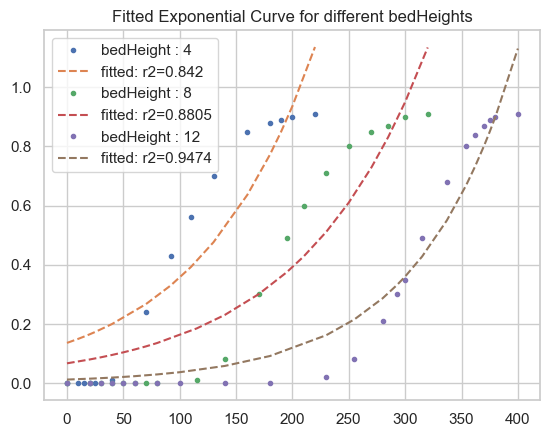

In [98]:
import adams_bohart_kinetic_model
importlib.reload(adams_bohart_kinetic_model)
from adams_bohart_kinetic_model import fit_adams_bohart_kinetic_model

adams_bed_4_model_params = fit_adams_bohart_kinetic_model(bed_4, m=4, Co= 100, Q=8, name="bedHeight", value=4)
adams_bed_8_model_params = fit_adams_bohart_kinetic_model(bed_8, m=8, Co=100, Q=8, name="bedHeight", value=8)
adams_bed_12_model_params = fit_adams_bohart_kinetic_model(bed_12, m=12, Co=100, Q=8, name="bedHeight", value=12)

rsquared: 0.9204 Y = e^(0.0 * 100 * t) - (8.023359180316279e-05 * 4 * 1241.684)/0.1444043321299639
rsquared: 0.842 Y = e^(0.0 * 100 * t) - (9.662758567658692e-05 * 4 * 1493.0)/0.2888086642599278
rsquared: 0.7214 Y = e^(0.0 * 100 * t) - (0.00011563856049858773 * 4 * 1336.395)/0.4332129963898917


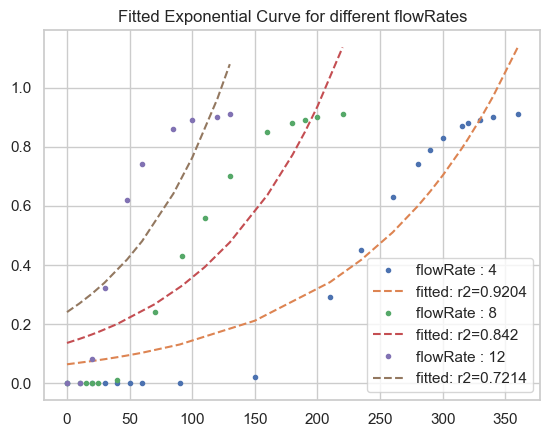

In [93]:
adams_flow_4_model_params = fit_adams_bohart_kinetic_model(flow_4, m=4, Co= 100, Q=4, name="flowRate", value=4)
adams_flow_8_model_params = fit_adams_bohart_kinetic_model(flow_8, m=4, Co=100, Q=8, name="flowRate", value=8)
adams_flow_12_model_params = fit_adams_bohart_kinetic_model(flow_12, m=4, Co=100, Q=12, name="flowRate", value=12)

rsquared: 0.8622 Y = e^(0.0 * 50 * t) - (0.00012328496153024625 * 4 * 1333.719)/0.2888086642599278
rsquared: 0.842 Y = e^(0.0 * 100 * t) - (9.662758567658692e-05 * 4 * 1493.0)/0.2888086642599278
rsquared: 0.6868 Y = e^(0.0 * 150 * t) - (9.563160808238351e-05 * 4 * 1086.542)/0.2888086642599278


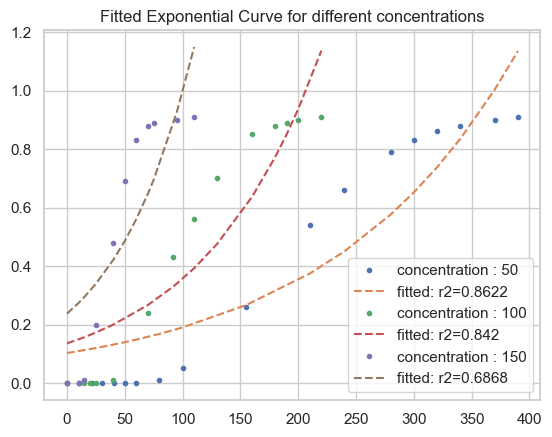

In [94]:
adams_conc_50_model_params = fit_adams_bohart_kinetic_model(data=conc_50, m=4, Co=50, Q=8, name="concentration", value=50)
adams_conc_100_model_params = fit_adams_bohart_kinetic_model(data=conc_100, m=4, Co=100, Q=8, name="concentration", value=100)
adams_conc_150_model_params = fit_adams_bohart_kinetic_model(data=conc_150, m=4, Co=150, Q=8, name="concentration", value=150)

rsquared: 0.7995 Y = e^(0.0 * 100 * t) - (0.00013724508092824206 * 4 * 1359.637)/0.4332129963898917
rsquared: 0.731 Y = e^(0.0 * 100 * t) - (0.00013374788671614035 * 4 * 1230.814)/0.4332129963898917
rsquared: 0.9605 Y = e^(0.0 * 100 * t) - (0.0002035724264530999 * 4 * 2053.726)/0.4332129963898917
rsquared: 0.9062 Y = e^(0.0 * 100 * t) - (0.00018289531298593071 * 4 * 1585.302)/0.4332129963898917


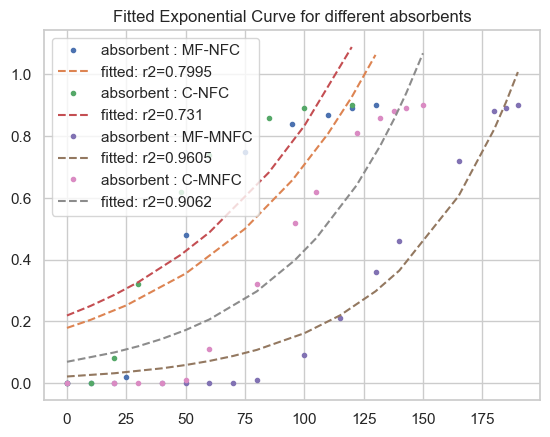

In [95]:
adams_mf_nfc_model_params = fit_adams_bohart_kinetic_model(absorbs_MF_NFC, Co=100, m=4, Q=12,name="absorbent", value="MF-NFC")
adams_c_nfc_model_params = fit_adams_bohart_kinetic_model(absorbs_C_NFC, Co=100, m=4, Q=12,name="absorbent", value="C-NFC")
adams_mf_mnfc_model_params = fit_adams_bohart_kinetic_model(absorbs_MF_MNFC, Co=100, m=4, Q=12,name="absorbent", value="MF-MNFC")
adams_c_mnfc_model_params = fit_adams_bohart_kinetic_model(absorbs_C_MNFC, Co=100, m=4, Q=12,name="absorbent", value="C-MNFC")

In [96]:
adams_bed_4_errors = kinetic_model_errors(adams_bed_4_model_params[1])
adams_bed_8_errors = kinetic_model_errors(adams_bed_8_model_params[1])
adams_bed_12_errors = kinetic_model_errors(adams_bed_12_model_params[1])
adams_flow_4_errors = kinetic_model_errors(adams_flow_4_model_params[1])
adams_flow_8_errors = kinetic_model_errors(adams_flow_8_model_params[1])
adams_flow_12_errors = kinetic_model_errors(adams_flow_12_model_params[1])
adams_conc_50_errors = kinetic_model_errors(adams_conc_50_model_params[1])
adams_conc_100_errors = kinetic_model_errors(adams_conc_100_model_params[1])
adams_conc_150_errors = kinetic_model_errors(adams_conc_150_model_params[1])
adams_mf_mnfc_errors = kinetic_model_errors(adams_mf_mnfc_model_params[1])
adams_c_mnfc_errors = kinetic_model_errors(adams_c_mnfc_model_params[1])
adams_mf_nfc_errors = kinetic_model_errors(adams_mf_nfc_model_params[1])
adams_c_nfc_errors = kinetic_model_errors(adams_c_nfc_model_params[1])

In [97]:
adams_bed_4_errors

{'coefficient of determination': 0.8420021925417739,
 'Marquardt': 6.895776708171714,
 'Sum of Squared Errors': 0.35836641360188287,
 'Sum of Absolute Errors': 2.1107170454584483,
 'Hybrid': 29.756245719709053,
 'Average Relative Error': 1.912544346574107,
 'Mean Squared Error': 0.023891094240125525,
 'Non Linear Chi-Square': 0.05625370417180384}

rsquared: 0.8420021926052885 Y = e^(0.14426450603663987 * 100 * t)/1493.0006777160431 - (0.14426450603663987 * 4)/0.2888086642599278
rsquared: 0.8804970725002909 Y = e^(0.09781427443887536 * 100 * t)/1103.7507809619729 - (0.09781427443887536 * 8)/0.2888086642599278
rsquared: 0.9474185040279884 Y = e^(0.10720152592566623 * 100 * t)/936.7997646132369 - (0.10720152592566623 * 12)/0.2888086642599278


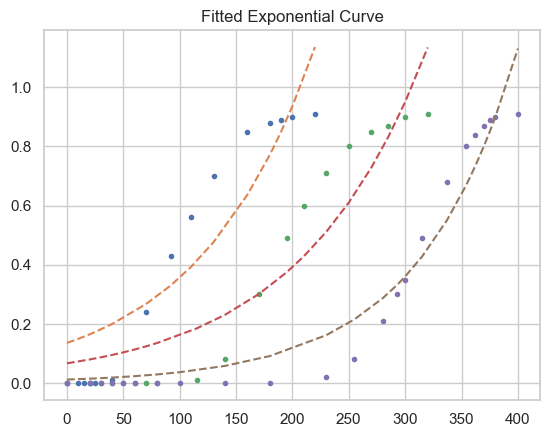

In [47]:
import wolborska_kinetic_model
importlib.reload(wolborska_kinetic_model)
from wolborska_kinetic_model import fit_wolborska_kinetic_model

wolborska_bed_4_model_params = fit_wolborska_kinetic_model(bed_4, m=4, Co= 100, Q=8, name="bedHeight", value=4)
wolborska_bed_8_model_params = fit_wolborska_kinetic_model(bed_8, m=8, Co=100, Q=8, name="bedHeight", value=8)
wolborska_bed_12_model_params = fit_wolborska_kinetic_model(bed_12, m=12, Co=100, Q=8, name="bedHeight", value=12)

rsquared: 0.9203715506677922 Y = e^(0.09962395524045392 * 100 * t)/1241.6849293480582 - (0.09962395524045392 * 4)/0.1444043321299639
rsquared: 0.8420021926052885 Y = e^(0.14426450603663987 * 100 * t)/1493.0006777160431 - (0.14426450603663987 * 4)/0.2888086642599278
rsquared: 0.721370739509398 Y = e^(0.15454254052200775 * 100 * t)/1336.3872096394514 - (0.15454254052200775 * 4)/0.4332129963898917


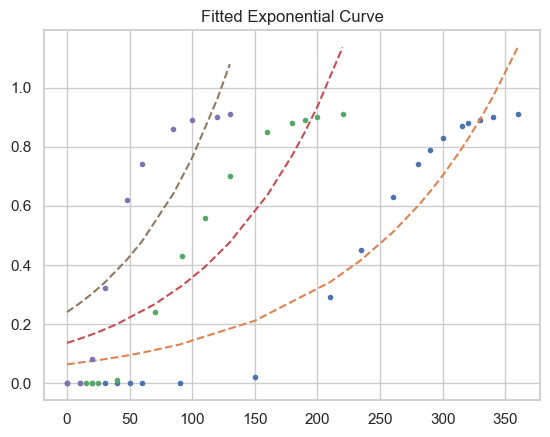

In [48]:
wolborska_flow_4_model_params = fit_wolborska_kinetic_model(flow_4, m=4, Co= 100, Q=4, name="flowRate", value=4)
wolborska_flow_8_model_params = fit_wolborska_kinetic_model(flow_8, m=4, Co=100, Q=8, name="flowRate", value=8)
wolborska_flow_12_model_params = fit_wolborska_kinetic_model(flow_12, m=4, Co=100, Q=12, name="flowRate", value=12)

rsquared: 0.8622278584249212 Y = e^(0.16442593433257555 * 50 * t)/1333.7209227635608 - (0.16442593433257555 * 4)/0.2888086642599278
rsquared: 0.8420021926052885 Y = e^(0.14426450603663987 * 100 * t)/1493.0006777160431 - (0.14426450603663987 * 4)/0.2888086642599278
rsquared: 0.6868075464906511 Y = e^(0.10390989263175239 * 150 * t)/1086.5362972056605 - (0.10390989263175239 * 4)/0.2888086642599278


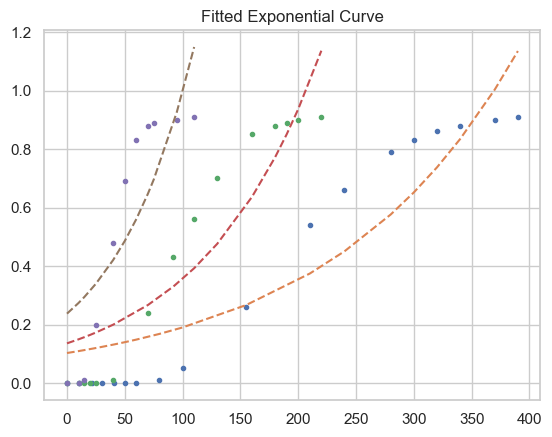

In [49]:
wolborska_conc_50_model_params = fit_wolborska_kinetic_model(data=conc_50, m=4, Co=50, Q=8, name="concentration", value=50)
wolborska_conc_100_model_params = fit_wolborska_kinetic_model(data=conc_100, m=4, Co=100, Q=8, name="concentration", value=100)
wolborska_conc_150_model_params = fit_wolborska_kinetic_model(data=conc_150, m=4, Co=150, Q=8, name="concentration", value=150)

rsquared: 0.7994829693016924 Y = e^(0.18660629818606647 * 100 * t)/1359.6333740083903 - (0.18660629818606647 * 4)/0.4332129963898917
rsquared: 0.7309673403946777 Y = e^(0.16461579467952928 * 100 * t)/1230.819315927341 - (0.16461579467952928 * 4)/0.4332129963898917
rsquared: 0.960508202671672 Y = e^(0.4180827503215189 * 100 * t)/2053.7261060082797 - (0.4180827503215189 * 4)/0.4332129963898917
rsquared: 0.906220191010825 Y = e^(0.28993946363399015 * 100 * t)/1585.304199085285 - (0.28993946363399015 * 4)/0.4332129963898917


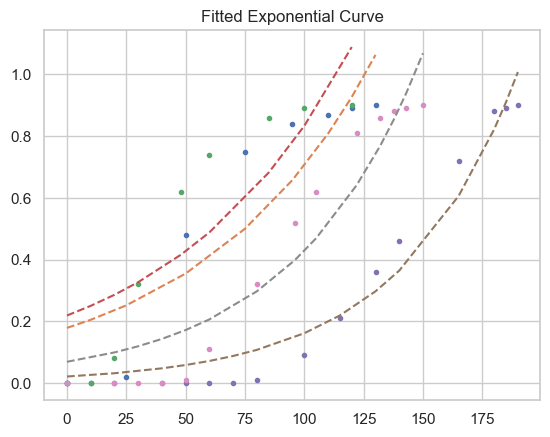

In [50]:
wolborska_mf_nfc_model_params = fit_wolborska_kinetic_model(absorbs_MF_NFC, Co=100, m=4, Q=12,name="absorbent", value="MF-NFC")
wolborska_c_nfc_model_params = fit_wolborska_kinetic_model(absorbs_C_NFC, Co=100, m=4, Q=12,name="absorbent", value="C-NFC")
wolborska_mf_mnfc_model_params = fit_wolborska_kinetic_model(absorbs_MF_MNFC, Co=100, m=4, Q=12,name="absorbent", value="MF-MNFC")
wolborska_c_mnfc_model_params = fit_wolborska_kinetic_model(absorbs_C_MNFC, Co=100, m=4, Q=12,name="absorbent", value="C-MNFC")

In [51]:
wolborska_bed_4_errors = kinetic_model_errors(wolborska_bed_4_model_params[1])
wolborska_bed_8_errors = kinetic_model_errors(wolborska_bed_8_model_params[1])
wolborska_bed_12_errors = kinetic_model_errors(wolborska_bed_12_model_params[1])
wolborska_flow_4_errors = kinetic_model_errors(wolborska_flow_4_model_params[1])
wolborska_flow_8_errors = kinetic_model_errors(wolborska_flow_8_model_params[1])
wolborska_flow_12_errors = kinetic_model_errors(wolborska_flow_12_model_params[1])
wolborska_conc_50_errors = kinetic_model_errors(wolborska_conc_50_model_params[1])
wolborska_conc_100_errors = kinetic_model_errors(wolborska_conc_100_model_params[1])
wolborska_conc_150_errors = kinetic_model_errors(wolborska_conc_150_model_params[1])
wolborska_mf_mnfc_errors = kinetic_model_errors(wolborska_mf_mnfc_model_params[1])
wolborska_c_mnfc_errors = kinetic_model_errors(wolborska_c_mnfc_model_params[1])
wolborska_mf_nfc_errors = kinetic_model_errors(wolborska_mf_nfc_model_params[1])
wolborska_c_nfc_errors = kinetic_model_errors(wolborska_c_nfc_model_params[1])

In [52]:
wolborska_c_mnfc_errors

{'coefficient of determination': 0.906220191010825,
 'Marquardt': 5.405207784547973,
 'Sum of Squared Errors': 0.1911500449510784,
 'Sum of Absolute Errors': 1.4848343417262133,
 'Hybrid': 23.68397040028265,
 'Average Relative Error': 1.5603490847173167,
 'Mean Squared Error': 0.013653574639362743,
 'Non Linear Chi-Square': 0.03155357288966905}